# Week 7: The Finite Difference Method

Name: Manav Bilakhia

Date: 18th October 2022

   ## Library Imports Go Here

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import time
import statistics
import random
from time import sleep
import scipy
import pandas as pd
from mpl_toolkits.mplot3d import axes3d
from scipy.sparse import coo_matrix, linalg

## A Generic Finite Difference Function

<font color = blue>
We are interested in solving the general equation type

$$
A(x)u'' + B(x)u' + C(x)u = \lambda u
$$

subject to the boundary conditions

$$
u(0) = u(x_{\infty}) = 0
$$

(by which we mean that we want to find both the eigenvalue $\lambda$ and the eigenfunction $u(x)$.)  The basic approach used today will be to transform this equation into a matrix equation in the form

$$
\mathbb{M}\vec{u} = \lambda\vec{u}
$$

and the focus will be on generating the matrix $\mathbb{M}$, which we can then use existing python libraries to analyze.

### A Matrix Generating Function

<font color = blue>
Construct a function that takes as inputs the three functions $A(x)$, $B(x)$, and $C(x)$, along with $N$, the total size-length of the matrix and $x_{\infty}$ the value of "numerical infinity", and outputs the matrix $\mathbb{M}$ (as an array.)  Test your matrix generator with $A = B = C = 1$, $x_{\infty} = 1$, and $N = 5$, and show the result.  Confirm that the entries to the matrix are correct.

In [2]:
def matrix_generation1(A, B, C, N, x_infty):
    array = np.array([[0 for i in range(N)] for j in range(N)])#matrix full of zeros
    x = 0 #initial x value
    delta_x = x_infty/(N+1) #calculating delta x
    array[0,0] = C(x) - 2*A(x)/delta_x**2 # filling the first row
    array[0, 1] = A(x)/delta_x**2 + B(x)/(2*delta_x) #filling the first row
    for j in range (1, N-1): # looping from second to penultimate row
        x = x+delta_x #updating x for each row
        array[j, j-1] = A(x)/delta_x**2 - B(x)/(2*delta_x) #left most element
        array[j, j] = C(x) - 2*A(x)/delta_x**2 #central element
        array[j, j+1] = A(x)/delta_x**2 + B(x)/(2*delta_x) #right element
    array[N-1, N-2] =  A(x)/delta_x**2 - B(x)/(2*delta_x)  #filling the last row
    array [N-1, N-1] =  C(x) - 2*A(x)/delta_x**2  #filling the last row
    return array
def A(x): #mathematical function A
    return 1
def B(x): #mathematical function B
    return 1
def C(x): #mathematical function C
    return 1
print(matrix_generation1(A, B, C, 5, 1))

[[-71  39   0   0   0]
 [ 33 -71  39   0   0]
 [  0  33 -71  39   0]
 [  0   0  33 -71  39]
 [  0   0   0  33 -71]]


The above function generates an NxN matrix whose values are decided by the mathematical functions A, B and C. 

### A Second Matrix Generating Function

<font color = blue>
There are many numerical methods that find the eigenvalues and eigenvectors of a matrix, but they are definitely not all created equal.  Even though we aren't learning the algorithms behind these methods, it is still useful to consider some of their differences.

There are a set of algorithms specifically designed to work on matrices which are "sparse", meaning that most of the elements in them are zero.  However, in order to use these algorithms, we have to create and store the matrix in a way other than the standard numpy array.  What we want to do here is write a second function for creating a matrix, but this time store it as a "sparse" matrix type.  

To do this you will need to use the library scipy.sparse.  There is more than one sparse matrix type (the differences are in how the data is stored in your computer), but the easiest one to create is the "coo" type, so you will need to use the function coo_matrix in the scipy.sparse library.  

Once you have your function for creating the matrix, you can take its output and convert it into a standard array using .toarray().  (This is helpful for making sure this code produces the same matrix you've just confirmed is correct in the previous code.)

In [3]:
def matrix_generation2(A, B, C, N, x_infty):
    array = np.linspace(0.0,x_infty, N+2)[1:-1] #initial array slicing out the first and the last element
    delta_x = x_infty/(N+1) #calculating delta x
    row = [0,0]# coords for the 1st row
    col = [0,1]# coords for the 1st row
    data = [C(array[0]) - 2*A(array[0])/(delta_x**2),A(array[0])/(delta_x**2) + B(array[0])/(2*delta_x)] #data for the first row
    for j in range (1, N-1): # looping from second to penultimate row
        left = A(array[j])/(delta_x**2) - B(array[j])/(2*delta_x) #left most element
        center = C(array[j]) - 2*A(array[j])/(delta_x**2) #central element
        right = A(array[j])/(delta_x**2) + B(array[j])/(2*delta_x) #right element
        row.extend([j]*3)  #generating coords for the jth row
        col.extend([j -1, j, j +1 ]) #generating coords for the jth row
        data.extend([left, center, right]) #calculating data for the jth row
    row.extend([N-1]*2) #generating coords for the last row
    col.extend([N-2, N-1]) #generating coords for the last row
    data.extend([A(array[N-1])/(delta_x**2) - B(array[N-1])/(2*delta_x), C(array[N-1]) - 2*A(array[N-1])/(delta_x**2)]) #data for the last row
    return np.array(row), np.array(col), np.array(data)  #return row, column, data

row, column, data = matrix_generation2(A, B, C, 5, 1) #getting row, column, data

print(coo_matrix((data, (row, column)), shape=(5, 5)).toarray()) #getting the coo matrix

[[-71.  39.   0.   0.   0.]
 [ 33. -71.  39.   0.   0.]
 [  0.  33. -71.  39.   0.]
 [  0.   0.  33. -71.  39.]
 [  0.   0.   0.  33. -71.]]


This is another matrix generator which uses the coo matrix function to generate it. We do this to mainly optimize the algorithm. 

### Comparing Linear Algebra Packages

<font color = blue>
Here, we will compare the efficiency of a method which uses sparse techniques with one that doesn't.  We will use the infinite square well system as an example, where

$$
A(x) = -1, \hspace{.75in} B(x) = C(x) = 0
$$

and

$$
x_{\infty} = 1
$$

For your standard numpy array matrix, use the function numpy.linalg.eigh.  For your sparse coo-type matrix use the function scipy.sparse.linalg.eigsh.  (Note that both of these functions assume the matrix you are providing is Hermetian, which when finding the energy eigenstates in quantum mechanics you always have.)

One thing to be aware of is that the "sparse" function is designed to generate only a subset of the total eigenvalues and eigenvectors (specified by the parameter $k$, which here we will set to 1.)  Furthermore, they are naturally ordered from largest magnitudes of eigenvalues to smallest.  We are more interested in the smallest magnitude eigenvalues, which we can get out by setting the parameter "sigma = 0".  


Using each of these two functions, determine the time required to compute the first eigenvalue/eigenvector for N in the range $[10, 1000]$, in steps of $10$.  Plot these two sets of times together on the same graph, and discuss which method is more efficient.


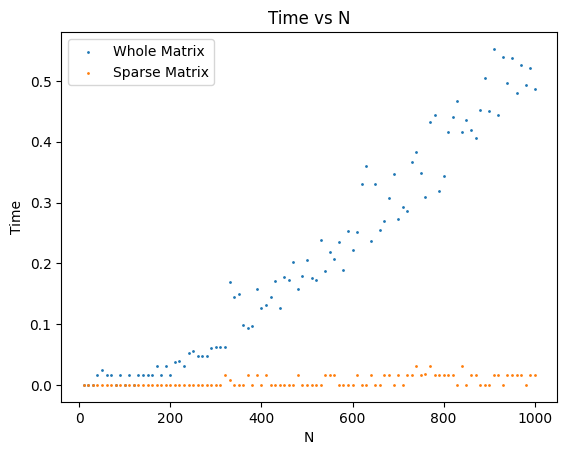

In [4]:
def A(x): #mathematical function A
    return -1

def B(x): #mathematical function B
    return 0

def C(x): #mathematical function C
    return 0

x_infty = 1 #numerical infinity
N_array = [int(i) for i in np.linspace(10, 1000,100)] # values of N
whole = [] #empty array  for whole method
sparse = [] #empty matrix for sparse method
for N in N_array: #looping through the list of N values
    current_time = time.time() #starting timer
    np.linalg.eigh(matrix_generation1(A, B, C, N, x_infty))# calculaitng  the eigen value
    total_time = time.time()-current_time #total time taken
    whole.append(total_time)# appending time to the list
    current_time = time.time() #starting timer
    row, column, data = matrix_generation2(A, B, C, N, x_infty)  #getting the sparse matrix
    linalg.eigsh(coo_matrix((data, (row, column)), shape=(N, N)), k=1, sigma = 0) #gettting the eigen value
    total_time = time.time()-current_time  #total time taken
    sparse.append(total_time) # appending time to the list
plt.scatter(N_array,whole, label = "Whole Matrix", s  = 1) #plotting whole matrix time
plt.scatter(N_array,sparse, label = "Sparse Matrix", s  = 1) #plotting sparse matrix time
plt.xlabel("N") #xlabel
plt.ylabel("Time") #ylabel
plt.title("Time vs N") #title
plt.legend()
plt.show()

In the graph above, we compare the efficiencies of the two algorithms for matrix generation. We see that the whole matrix is much slower than the sparse matrix as the value of N gradually increases.

## Hydrogen

<font color = blue>
Now we want to analyze the Hydrogen atom, where we are trying to solve the equation (in dimensionless form, as usual)

$$
-u'' + \frac{\ell(\ell+1)}{r^2}u - \frac{2}{r}u + u = \hat{E}u
$$

Remember that here, length is measured in units of the Bohr radius, and energy is measured in units of the Rydberg energy, but with an upward shift of $+1$ so that

$$
\tilde{E} = \hat{E} - 1
$$

The value $\ell$ is the quantum number associated with the magnitude of angular momentum.  With this non-dimensionalization, the energy spectrum should be

$$
\tilde{E}_n = -\frac{1}{n^2}, \hspace{.5in} \mbox{or} \hspace{.5in} \hat{E}_n = 1 - \frac{1}{n^2}.
$$

### Preliminaries

<font color = blue>
First create a function that takes as input the value of $\ell$ as well as the choice of "numerical infinity" and the value of $N$, and outputs the appropriate matrix.

In [5]:
def hydrogen(l,N, x_infty):
    def A(x):  #mathematical function A
        return -1
    def B(x):  #mathematical function A
        return 0
    def C(x):  #mathematical function A
        return l*(l+1)/x**2 - 2/x +1 
    row, column, data = matrix_generation2(A, B, C, N, x_infty) #getting the row coulmn and data
    return row, column, data

row, column, data = hydrogen(1,4, 1) #getting data from the hydrogen function
print(coo_matrix((data, (row, column)), shape=(4, 4)).toarray()) #making and printing the matrix

[[ 91.         -25.           0.           0.        ]
 [-25.          58.5        -25.           0.        ]
 [  0.         -25.          53.22222222 -25.        ]
 [  0.           0.         -25.          51.625     ]]


The above function is just a check to see if we get the right matrix

### Eigenvalues

#### * Zero Angular Momentum States

<font color = blue>
Now, use your function to genererate the energy spectrum of the lowest ten energies of hydrogen, with $\ell = 0$. Create arrays with entries $[n]$ and $[\tilde{E}_n]$, and plot this together with a curve showing the theoretical spectrum.  (Don't forget to shift the energies back from $\hat{E}$ to $\tilde{E}$!)  For this exercise, use $x_{\infty} = 1000$ and $N = 100000$.

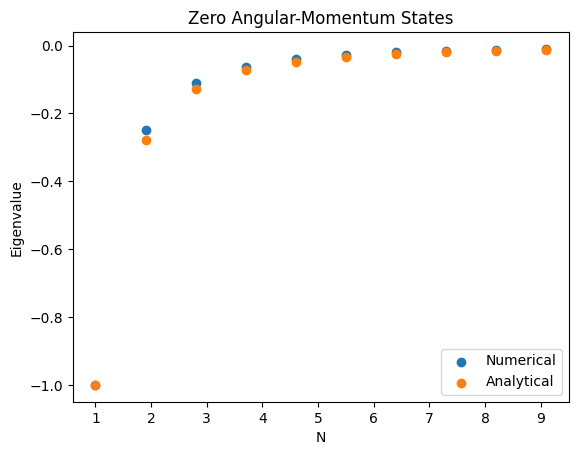

In [6]:
def analytical(x): #mathematical function defining the analytical solution
    return -1/x**2
row, column, data = hydrogen(0, 100000, 1000) #getting data from the hydrogen function
eigen_value =  [(i-1) for i in linalg.eigsh(coo_matrix((data, (row, column)), shape=(100000, 100000)), k=10, sigma = 0)[0]] #getting the eigenvalue from the matrix
x_vals = np.linspace(1,10, 11)[:-1] #x_vals
plt.scatter(x_vals, eigen_value, label = "Numerical") #plotting the numerical values
plt.scatter(x_vals, analytical(x_vals), label = "Analytical") #plotting the analytical
plt.title('Zero Angular-Momentum States')# title
plt.xlabel('N')#xlabel
plt.ylabel('Eigenvalue') #ylabel
plt.legend()
plt.show()

We see that the first 10 eigenvalues are between -1 and 0. The graph somewhat resembles the $\frac{1}{n^2}$ curve where n is the principle quantum number which is also what we expected. 

#### * Non-Zero Angular Momentum States

<font color = blue>
Then, use your function to also generate lists of energies for $\ell = 1$ and $\ell = 2$.  (Use the same $x_{\infty}$ and $N$ values.)

One of the most interesting physical phenomena in this system is "degeneracy": there are multiple different values of $\ell$ which lead to the same energy for a generate energy level in this system.  In order to demonstrate this, create a graph showing all three values of $\ell$.  Put energy on the vertical axis, and $\ell$-value on the horizontal axis.  In order to emphasize the degeneracy of the spectrum, add horizontal lines at each energy level.

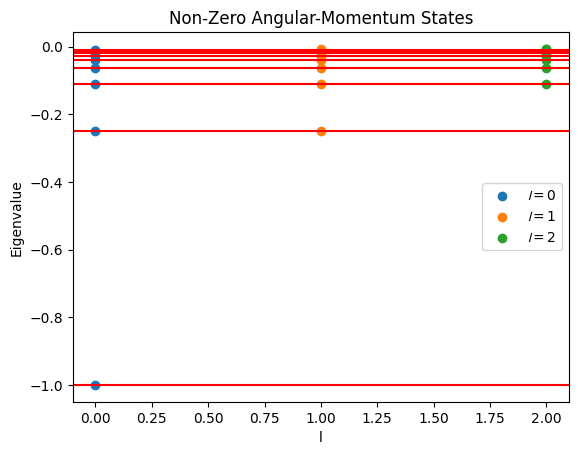

In [7]:
row, column, data = hydrogen(0,100000, 1000) #getting data from the hydrogen function
eigen_value = [(i-1) for i in linalg.eigsh(coo_matrix((data, (row, column)), shape=(100000, 100000)), k=10, sigma = 0)[0]] #getting the eigenvalue from the matrix
x_vals1 = np.array([0 for i in range(10)])# value of l
row1, column1, data1 = hydrogen(1,100000, 1000) #getting data from the hydrogen function
eigen_value1 = [(i-1) for i in linalg.eigsh(coo_matrix((data1, (row1, column1)), shape=(100000, 100000)), k=10, sigma = 0)[0]] #getting the eigenvalue from the matrix
x_vals2 = np.array([1 for i in range(10)]) # value of l
row2, column2, data2 = hydrogen(2,100000, 1000) #getting data from the hydrogen function
eigen_value2 = [(i-1) for i in linalg.eigsh(coo_matrix((data2, (row2, column2)), shape=(100000, 100000)), k=10, sigma = 0)[0]] #getting the eigenvalue from the matrix
x_vals3 = np.array([2 for i in range(10)]) # value of l


plt.scatter(x_vals1, eigen_value, label= '$\\mathcal{l}=0$') #plotting l = 0
plt.scatter(x_vals2, eigen_value1, label= '$\\mathcal{l}=1$') #plotting l = 1
plt.scatter(x_vals3, eigen_value2, label= '$\\mathcal{l}=2$')#plotting l = 2
for value in eigen_value: #plotting horizontal lines to show degeneracy 
    plt.axhline(y = value, color = 'r', linestyle = '-')
plt.title('Non-Zero Angular-Momentum States') #title 
plt.xlabel('l') #xlabel
plt.ylabel('Eigenvalue') #ylabel
plt.legend()
plt.show()

Here the main things to notice is that we have energy degeneracy for non zero angular momentum. we see that eigenvalue $l = 1, n = 0$ is equal to $l = 0, n = 1$. 

### Eigenvectors

#### Anaytlic Comparisons

<font color = blue>
Now let's make some comparisons between the eigenvectors generated numerically and the known analytic functions for the radial wavefunction $R(r)$.  Use the "eigsh" function to generate the eigenvectors associated with the sets of quantum numbers $(n = 1, \ell = 0)$, $(n - 2, \ell = 0)$, and $(n = 2, \ell = 1)$.  For this, use $x_{\infty} = 1000$ and $N = 100000$.  Convert these lists into discrete approximations of the radial wavefunction

$$
R(r) = \frac{u(r)}{r}
$$

In addition, create a list of $r$-coordinates $[r_n]$.  Then plot each, together with its analytic, known solution:

$$
n = 1, \ell = 0: \hspace{.5in} R(r) \propto e^{-r}
$$

$$
n = 2, \ell = 0: \hspace{.5in} R(r) \propto \left(1 - \frac{r}{2}\right)e^{-r/2}
$$

$$
n = 2, \ell = 1: \hspace{.5in} R(r) \propto r e^{-r/2}
$$

(you will have to manually "tune" a constant of proportionality in each case until it fits well.)

In [8]:
row1, column1, data1 = hydrogen(0,100000, 1000)#getting data from the hydrogen function
value, vector = linalg.eigsh(coo_matrix((data1, (row1, column1)), shape=(100000, 100000)), k=2, sigma = 0) #unpacking the eigenvalue and eigenvector

n1_l0 = np.array([vector[j][0] for j in range(100000)]) # getting the eigenvector
n2_l0 = np.array([vector[j][1] for j in range(100000)])  # getting the eigenvector
row2, column2, data2 = hydrogen(1,100000, 1000)#getting data from the hydrogen function
value, vector = linalg.eigsh(coo_matrix((data2, (row2, column2)), shape=(100000, 100000)), k=2, sigma = 0)#unpacking the eigenvalue
n2_l1 = np.array([vector[j][0] for j in range(100000)]) # getting the eigenvector



delta_rho = 1000/(100000+1)# calculating the value of rho

rho_array = np.zeros(100000) #making initial rho array
for i in range (100000): #computing R(r) from U(r)
    rho_j = (i+1)*delta_rho #updating delta rho
    n1_l0[i] = n1_l0[i]/rho_j #R(r)
    n2_l0[i] = n2_l0[i]/rho_j #R(r)
    n2_l1[i] = n2_l1[i]/rho_j #R(r)
    rho_array[i] = rho_j #updating the value of rho in the array


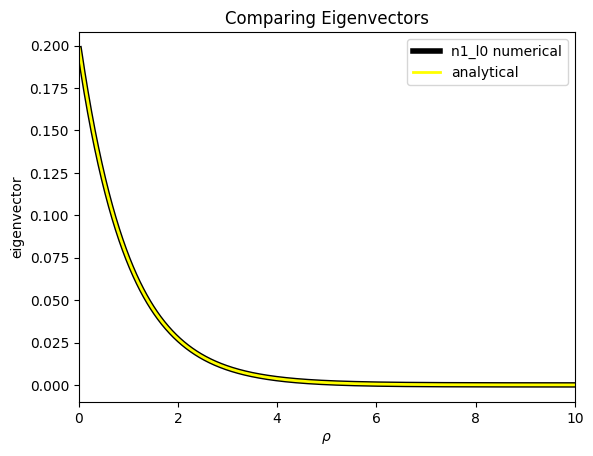

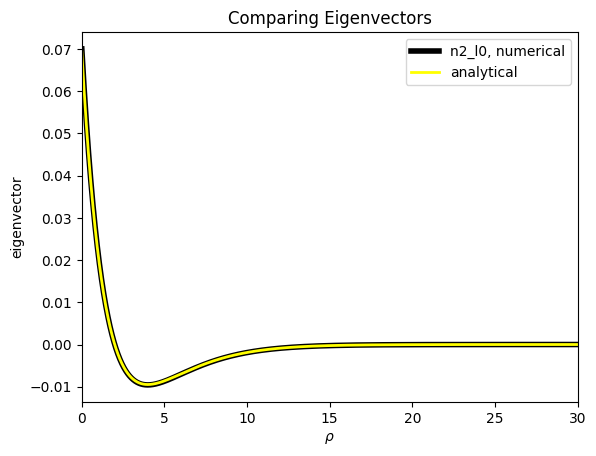

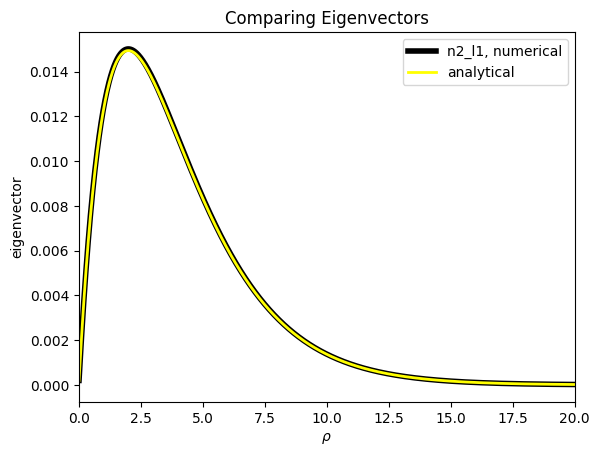

In [9]:
plt.plot(rho_array,   n1_l0, label = "n1_l0 numerical",color = "black", linewidth = 4) #plotting computational n1_l0
plt.plot(rho_array, 0.2*np.exp(-1*rho_array), color  = "yellow", linewidth = 2,label = "analytical") #plotting analytical n1_l0
plt.xlim(0, 10) #setting the x range
plt.title ("Comparing Eigenvectors")#title
plt.xlabel("$\\rho$") #xlabel
plt.ylabel("eigenvector") #ylabel
plt.legend()
plt.show()
plt.plot(rho_array,   -1*n2_l0, label = "n2_l0, numerical",color = "black", linewidth = 4) #plotting computational n2_l0
plt.plot(rho_array, 0.07*(1-rho_array/2)*np.exp(-1*rho_array/2), color  = "yellow", linewidth = 2,label = "analytical")  #plotting analytical n2_l0
plt.xlim(0, 30) #setting the x range
plt.title ("Comparing Eigenvectors")#title
plt.xlabel("$\\rho$") #xlabel
plt.ylabel("eigenvector") #ylabel
plt.legend()
plt.show()
plt.plot(rho_array,   n2_l1, label = "n2_l1, numerical",color = "black", linewidth = 4) #plotting computational n2_l1
plt.plot(rho_array, (n2_l1[0]/rho_array[0])*(rho_array)*np.exp(-1*rho_array/2), color  = "yellow", linewidth = 2,label = "analytical") #plotting analytical n2_l1
plt.xlim(0, 20) #setting the x range
plt.title ("Comparing Eigenvectors")#title
plt.xlabel("$\\rho$") #xlabel
plt.ylabel("eigenvector") #ylabel
plt.legend()
plt.show()

Here we see that the numerical values are completely consistent with our analytical function. 

#### The Role of $\Delta x$

<font color = blue>
We would now like to examine the roll that $\Delta x$ plays in limiting the accuracy and applicability of our numerical method.  To do so, consider the radial wavefunction $R(r)$ with $n = 4$ and $\ell = 1$.  Create plots of this wavefunction for different values of $N$:

$$N = 100000$$

$$N = 10000$$

$$N = 1000$$

$$N = 100$$

all with $x_{\infty} = 1000.$  (Note that the normalization of the eigenvector will change as you change $N$.)

This corresponds to four different choices of $\Delta x$.  For what values do you think the wavefunction is well represented?  What, in general, must be true of $\Delta x$ in order for the finite different method to work well (on a particular wavefunction)?

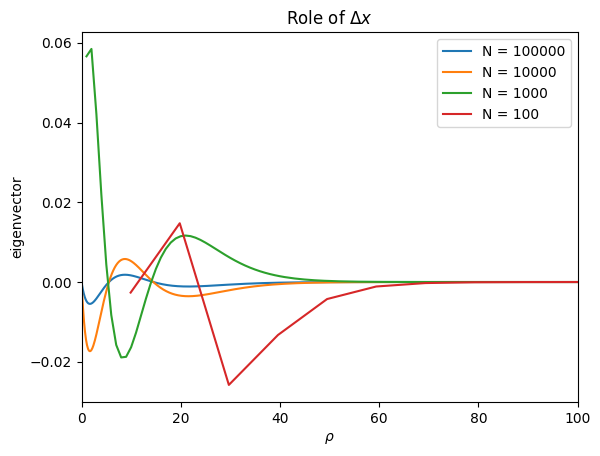

In [10]:
def role_delta_x(N): #function that makes my life easy and shows the role of delta_x
    row1, column1, data1 = hydrogen(1,N, 1000) #getting data from the hydrogen function
    value, vector = linalg.eigsh(coo_matrix((data1, (row1, column1)), shape=(N, N)), k=3, sigma = 0) #unpacking the eigenvalue and eigenvector

    n4_l1 = np.array([vector[j][2] for j in range(N)]) #getting the eigen vector

    delta_rho = 1000/(N+1) #computing delta rho

    rho_array = np.zeros(N) #initial array of delta rho
    for i in range (N): #computing R(r) from U(r)
        rho_j = (i+1)*delta_rho #updating delta rho
        n4_l1[i] = n4_l1[i]/rho_j #R(r)
        rho_array[i] = rho_j #updating the value of rho in the array
    return rho_array, n4_l1

rho_array_1,   n4_l1_1  = role_delta_x(100000) #unpacking 
rho_array_2,   n4_l1_2  = role_delta_x(10000) #unpacking
rho_array_3,   n4_l1_3  = role_delta_x(1000) #unpacking
rho_array_4,   n4_l1_4  = role_delta_x(100) #unpacking
plt.plot(rho_array_1,   n4_l1_1, label = "N = 100000") #plotting N = 100000
plt.plot(rho_array_2,   n4_l1_2, label = "N = 10000") #plotting N = 10000
plt.plot(rho_array_3,   n4_l1_3, label = "N = 1000")#plotting N = 1000
plt.plot(rho_array_4,   n4_l1_4, label = "N = 100") #plotting N = 100
plt.title ("Role of $\\Delta x$")#title
plt.xlabel("$\\rho$") #xlabel
plt.ylabel("eigenvector") #ylabel
plt.xlim(0,100) #setting the x range 
plt.legend()
plt.show()

Here we see that as our value of N decreases, we see that the starting point of the graph moves away from zero. This is because, for a smaller value of N, the step size $\Delta x$ increases  The interesting thing here is that each graph has a different shape 

#### The Role of $x_{\infty}$

<font color = blue>
Now let's consider the first 10 eigenstates with $\ell = 0$, but use $x_{\infty} = 100$ and $N = 10000$ (notice that we have kept the spacing $\Delta x$ roughly the same as in our original work.  First, find the lowest ten energy eigenvalues.  What is strange (and not correct) about the last couple?  Generate the actual eigenvector corresponding to the 10th eigenvalue, and then generate it again with $x_{\infty} = 1000$ and $N = 100000$, and plot the two (in this case, it's more useful to plot $u(r)$ than to plot $R(r)$.)  What must be true of the choice of numerical infinity, in order for the eigenfunction and eigenvalue to be effectively estimated?

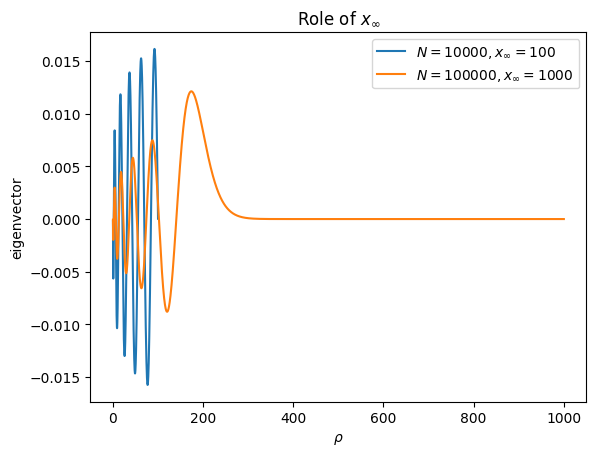

In [11]:
row1, column1, data1 = hydrogen(0,10000, 100)  #getting data from the hydrogen function
value, vector = linalg.eigsh(coo_matrix((data1, (row1, column1)), shape=(10000, 10000)), k=10, sigma = 0)  #unpacking the eigenvalue and eigenvector
eigen_vector = np.array([vector[j][9] for j in range(10000)]) #getting the desired eigen vector
delta_rho = 100/(10000+1) #computing delta rho

rho_array = np.zeros(10000) #initial array of delta rho
for i in range (10000): #computing R(r) from U(r)
    rho_j = (i+1)*delta_rho #updating delta rho
    rho_array[i] = rho_j  #updating the value of rho in the array
plt.plot(rho_array, eigen_vector , label = "$N = 10000, x_{\\infty} = 100$") #plotting the rho array vs U(r)

row1, column1, data1 = hydrogen(0,100000, 1000)  #getting data from the hydrogen function
value, vector = linalg.eigsh(coo_matrix((data1, (row1, column1)), shape=(100000, 100000)), k=10, sigma = 0)  #unpacking the eigenvalue and eigenvector
eigen_vector = np.array([vector[j][9] for j in range(100000)]) #getting the desired eigen vector
delta_rho = 1000/(100000+1) #computing delta rho

rho_array = np.zeros(100000)  #initial array of delta rho
for i in range (100000):  #computing R(r) from U(r)
    rho_j = (i+1)*delta_rho  #updating delta rho
    rho_array[i] = rho_j #updating the value of rho in the array
plt.plot(rho_array, eigen_vector, label = "$N = 100000, x_{\\infty} = 1000$")#plotting the rho array vs U(r)
plt.title ("Role of $x_{\\infty}$")#title
plt.xlabel("$\\rho$") #xlabel
plt.ylabel("eigenvector") #ylabel
plt.legend()
plt.show()

The last two eighenvalues here are positive which does not make sense physically. It at the same time, computationally it makes complete sense as we see that the for a smaller value of $x_{\infty}$ the wave function never tends to zero which suggests that our system was too small for this wave. In the second graph, we see that our system is much bigger and can encompass the entire wave behavior as it tends to 0. 

## The Numerical Algorithms

<font color = blue>
We want code that will solve (find $\tau(s)$) for the generic heat equation
    $$
    \lambda(s)\tau''(s) + \lambda'(s)\tau'(s) = -h(s)
    $$
where the functions $\lambda(s)$ and $h(s)$ are given, and the boundary conditions for $\tau(s)$ are:
    $$
    \tau(0) = 0 \, , \hspace{.5in} \tau(1) = 1
    $$
In order to do this, we convert the equation into a matrix problem of the form
    $$
    \mathbb{M}\vec{\tau} = -(\vec{h} + \vec{b})
    $$

### Generating the Matrix

<font color = blue>
Create a function that will build the matrix $\mathbb{M}$.  Your matrix should take as inputs the size of the matrix $N$, and the function $\lambda(s)$, and should use produce a sparse array.  You should be able to start with the function you created in the previous assignment and create a function which uses it.  Use a numerical derivative to find the function $\lambda'(s)$ with an $\epsilon$ parameter set to be 1/100 of the grid spacing.

In [12]:
def M(N, lambda_s): #bulding matrix M
    delta_s = 1/ (N+1) #delta_s 
    epsilon = 1/100*delta_s #epsilon
    
    def A(s): #mathematical function A
        return lambda_s(s)
    def B(s): #mathematical function B
        return (lambda_s(s + epsilon) - lambda_s(s)) / epsilon
    def C(s): #mathematical function C
        return 0
    
    row, column, data = matrix_generation2(A, B, C, N, 1) #getting data to generate a sparse matrix
    matrix = coo_matrix((data, (row, column)), shape=(N, N)) #building the sparse matrix
    return matrix

The above function uses our sparse matrix generator to generate a matrix for the heat equation

### Generating the Source Matrix

<font color = blue>
Create a function that will build the vector $\vec{h}$.  It should take as inputs the size of the vector $N$ and the function $h(s)$.  (Note that this is not typically sparse, so there's no point it using SparseArray).

In [13]:
def source(N, H): #making the source matrix which builds the 
    delta_s = 1/(N+1) #delta_s 
    H_matrix = [] #declaring the H vector
    for i in range(1, N+1): #looping over the size of the vector
        H_matrix.append([H(i*delta_s)]) #adding values to the vector
    return np.array(H_matrix)

The above function generates a matrix using our sparse matrix generator for the source

### Generating the Boundary Vector

<font color = blue>
Create a function that generates the vector $\vec{b}$ in which you will encode your boundary conditions.  It should take as inputs the size of the vector $N$ and the function $\lambda(s)$, and use the same mechanism as before to calculate the numerical derivative $\lambda'(s)$.  Test that it is working for $N = 4$ and $\lambda(s) = 1$.

We could work hard at it and generate this in sparse form, but it turns out not to be super-important.  Essentially the "sparse" structure is designed to make sure we don't use up memory space in the computer storing a bunch of zeroes: instead we only store those elements of the matrix or vector which are non-zero.  But in this problem the matrix you have just created will have of order $N$ non-zero elements.  If we now store all $N$ elements of the vector $\vec{b}$, even those which aren't zero, we haven't changed the scaling of the number of values we are storing (it is still just of order $N$).

In [14]:
def boundary(N, lambda_s): #defining the boundary condition
    t0 = 0 #setting t0
    t1 = 1 #setting t1
    delta_s = 1/(N+1) #calculating delta_s
    epsilon = 1/100*delta_s #calculating epsilon
    
    def A(s): #mathematical function A
        return lambda_s(s)
    def B(s): #mathematical function B
        return (lambda_s(s + epsilon) - lambda_s(s)) / epsilon
    
    b_vector = [[(A(delta_s)/delta_s**2 - B(delta_s)/(2*delta_s))*t0]] #making the boundary vector using the mathematical functions
    for i in range(2, N): #looping over the size of the vector
        b_vector.append([0]) # giving the valuie of zero to the entire vector except the last element
    b_vector.append([(A(delta_s*N)/delta_s**2 + B(delta_s*N)/(2*delta_s))*t1])# adding the last element
    return np.array(b_vector)

The above function generated the boundary condition vector with the middle elements all being 0

### The Solution Maker

<font color = blue>
We now want to use these pieces to create solutions to our differential equation

#### Solution Function

<font color = blue>
    Write a function that will take as inputs the size of the grid $N$, the source function $h(s)$ and conductivity $\lambda(s)$, and will output the solution to the differential equation in the form of two lists $[s_i]$ and $[\tau_i]$.  Your function should use the function scipy.sparse.linalg.inv to invert the matrix.

In [15]:
def solution(N, H, lambda_s): # function returns the solution to the differential equations
    delta_s = 1/(N+1) # calculating delta_s
    s_list = [delta_s*i for i in range(1,N+1)] # making a list of s that increase with the size of the matrix
    M_inverse = linalg.inv(M(N, lambda_s))#inversing the matrix
    H_matrix = source(N, H)# generating the source matrix
    b_vector = boundary(N, lambda_s) #generating the boundary vector
    tau = np.dot(M_inverse.toarray(), np.add(H_matrix,b_vector))*(-1)#calculating tau
    return np.array(s_list), tau#returning [s] and [tau]

The above function calculates the value of tau for a given source and boundary

#### A Simple Test

<font color = blue>
Test your function with the case $\lambda(s) = 1$ and $h(s) = 0$, using $N = 1000$.  Confirm that the solution matches the expected analytic solution $\tau(s) = s$.

C:\Users\manav\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
C:\Users\manav\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:239: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


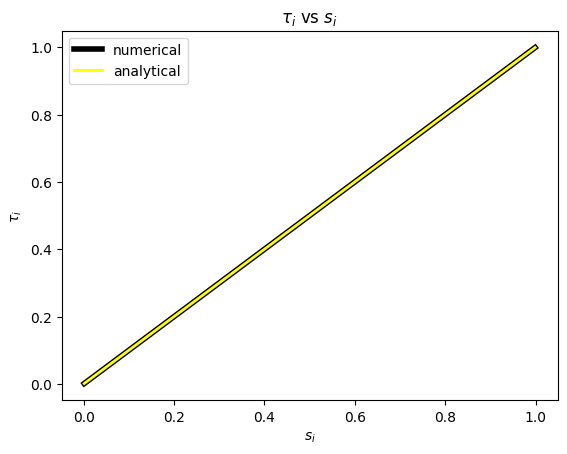

In [16]:
def lambda_s(s): #lambda s
    return 1
def H(s): # H(s)
    return 0
def analyticalTau(s):#analytical tau
    return s

s_list, tau = solution(1000, H, lambda_s) #getting the numerical solution
analytical = analyticalTau(s_list) #getting the analytical value



plt.plot(s_list,tau, linewidth = 4.0, color = 'black', label= 'numerical') #plotting the numerical solution
plt.plot(s_list,analytical, linewidth = 2.0, color = 'yellow', label= 'analytical') #plotting the analytical solution
plt.title('$\\tau_{i}$ vs $s_i$') #title
plt.xlabel('$s_i$') #xlabel
plt.ylabel('$\\tau_{i}$')#ylabel
plt.legend()
plt.show()

Here we know that the material has uniform conductivity. The graph also shows a perfect overlap for our numerical method and analytical solution. 

## * Exploring the Heat Equation

<font color = blue>
    Now that we have the basic elements to produce solutions to the heat equation in 1D, we want to experiment with them.

### Linearly Varying Conductivity

<font color = blue>
   Consider the case where the conductivity of the rod varies linearly along it, in the form
    $$
    \lambda(s) = 1 + \beta s
    $$
    but there is still no source term.

#### Comparing with the Analytic Solution

<font color = blue>
In this case, it is also possible to find the solution analytically, and it is given by

$$
\tau(s) = \frac{\log(1 + \beta s)}{\log(1 + \beta)}
$$
    
Use your algorithm to find a solution for $\beta = 1$, and graph it together with the analytic solution.  Do they agree?

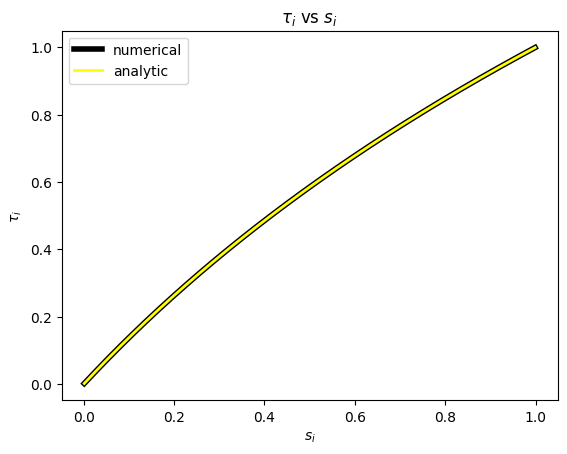

In [17]:
def lambda_s(s): #lambda s
    return 1+beta*s
def analyticaltau2(s): #analytical tau
    return np.log(1 + beta*s)/np.log(1 + beta)

beta = 1
s_list2, tau2 = solution(1000, H, lambda_s) #getting the numerical solution
analytical = analyticaltau2(s_list) #getting the analytical value



plt.plot(s_list2,tau2, linewidth = 4.0, color = 'black', label= 'numerical') #plotting the numerical solution
plt.plot(s_list2,analytical, linewidth = 2.0, color = 'yellow', label= 'analytic') #plotting the analytical solution
plt.title('$\\tau_{i}$ vs $s_i$') #title
plt.xlabel('$s_i$') #xlabel
plt.ylabel('$\\tau_{i}$') #ylabel
plt.legend()
plt.show()

Here we have a material with a linearly varying conductivity hence we see its not an exact linear curve. With increasing conductivity, we see that the gradient of temperature decreases. We again see that the numerical results align perfectly with our analytical solution

#### Varying $\beta$

<font color = blue>
    Now create a graph which shows the solutions for $\beta = -0.99, -0.9, 0, 10, 100$.

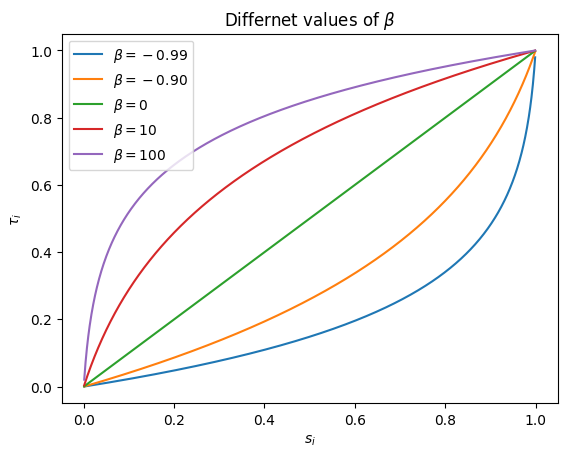

In [18]:
beta = -0.99                                    #value of beta                                                         
s_list, tau = solution(N, H, lambda_s)          #getting the numerical solution                         
plt.plot(s_list,tau, label= "$\\beta = -0.99$") #plotting the numerical solution                              
beta = -0.90                                    #value of beta                                                             
s_list, tau = solution(N, H, lambda_s)          #getting the numerical solution                                           
plt.plot(s_list,tau, label= "$\\beta = -0.90$") #plotting the numerical solution                                              
beta = 0                                        #value of beta                                                            
s_list, tau = solution(N, H, lambda_s)          #getting the numerical solution                                                                           
plt.plot(s_list,tau, label= "$\\beta = 0$")     #plotting the numerical solution                                                                               
beta = 10                                       #value of beta                                                                                                            
s_list, tau = solution(N, H, lambda_s)          #getting the numerical solution                                    
plt.plot(s_list,tau, label= "$\\beta = 10$")    #plotting the numerical solution                                                                                
beta = 100                                      #value of beta                                                                
s_list, tau = solution(N, H, lambda_s)          #getting the numerical solution                                                                           
plt.plot(s_list,tau, label= "$\\beta = 100$")   #plotting the numerical solution
plt.title('Differnet values of $\\beta$')       #title
plt.xlabel('$s_i$') #xlabel
plt.ylabel('$\\tau_{i}$') #ylabel
plt.legend()
plt.show()

Here we now want to examine what happens with a varying value of $\beta$. For positive values of $\beta$, we see that the conductivity increases. For negative value of $\beta$ we know that the conductivity decreases. as expected $\beta = 0$ is perfectly linear. This is again consistent with what we had expected as the relation between temperature and conductivity

### Sinusoidally Varying Conductivity

<font color = blue>
    Now let's consider the case where the conductivity varies sinusoidally across the rod (so parts of the rod which have high conductivity are interspersed with parts of the rod which have low conductivity).  Let's say
    $$
    \lambda(s) = 1 + A\sin(k s)
    $$
    where $A = 0.99$ and $k = 20$.  Create plots of both the conductivity itself and the temperature across the rod.

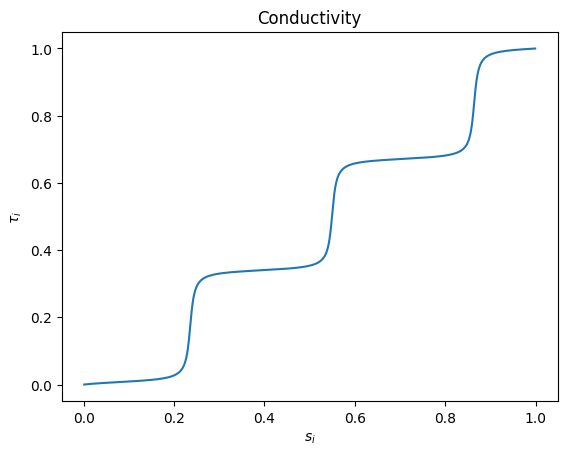

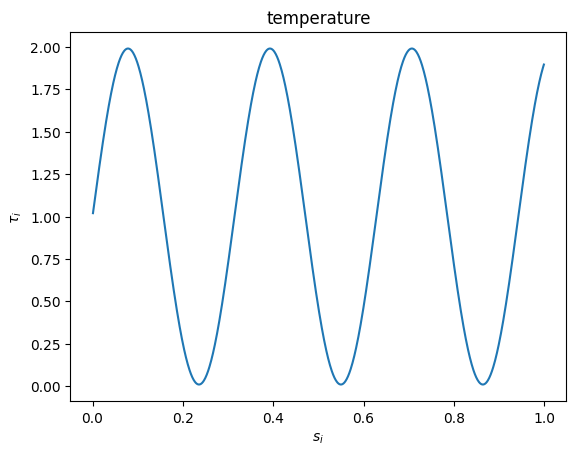

In [19]:
def lambda_s(s): #conductivity
    return 1 + 0.99*np.sin(20*s)


s_list, tau = solution(1000, H, lambda_s) #getting the numerical solution


plt.plot(s_list,tau) #plotting the numerical solution            
plt.title('Conductivity')#title
plt.xlabel('$s_i$') #xlabel
plt.ylabel('$\\tau_{i}$') #ylabel
plt.show()


plt.plot(s_list,lambda_s(s_list)) #plotting the numerical solution            
plt.title('temperature')#title
plt.xlabel('$s_i$') #xlabel
plt.ylabel('$\\tau_{i}$') #ylabel
plt.show()

We see that the conductivity of the material is continuosly changing sinusoidally as expected. 

### Source Terms

<font color = blue>
    Now consider a rod with constant conductivity $\lambda(s) = 1$, but with a non-trivial source term in the form
    $$
    h(s) = \frac{h_0}{\sigma\sqrt{\pi}}e^{-(s - s_0)^2/\sigma^2}
    $$
    
This Gaussian function is appropriate for modeling sources that are nearly point-like, with $s_0$ giving the location of the source, $h_0$ giving its strength, and $\sigma$ giving the width it is spread out over.  (Choosing $\sigma$ small makes it closer to a delta-function source).

#### The Significance of $h_0$

<font color = blue>
Create a single graph that shows solutions with $\sigma = 0.01$ and $s_0 = 0.5$, but with $h_0$ in the set

$$
h_0 \in \{-10, 1, 0, 1, 10\}
$$

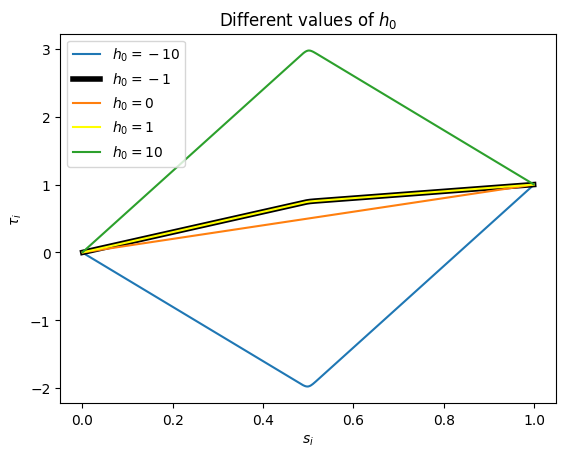

In [20]:
def lambda_s(s): #conductivity
    return 1

def H(s): # H(s)
    return h_0/(sigma*np.sqrt(np.pi))*np.exp(-(s-s_0)**2/sigma**2)

sigma = 0.01 #sigma
s_0=0.5 #location of the source
h_0 = -10                                                                       #strength                                        
s_list, tau = solution(1000, H, lambda_s)                                       #getting the numerical solution         
plt.plot(s_list,tau , label = "$h_{0} = -10$")                                  #plotting the numerical solution                                      
h_0 = 1                                                                         #strength                                                                                   
s_list, tau = solution(1000, H, lambda_s)                                       #getting the numerical solution                                                                                               
plt.plot(s_list,tau, label = "$h_{0} = -1$",linewidth = 4, color = "black")     #plotting the numerical solution                                                                                                                                
h_0 = 0                                                                         #strength                                                                                   
s_list, tau = solution(1000, H, lambda_s)                                       #getting the numerical solution                                                                                               
plt.plot(s_list,tau, label = "$h_{0} = 0$")                                     #plotting the numerical solution                                                                                                
h_0 = 1                                                                         #strength                                                                                   
s_list, tau = solution(1000, H, lambda_s)                                       #getting the numerical solution                                                                                               
plt.plot(s_list,tau, label = "$h_{0} = 1$",color = "yellow")                    #plotting the numerical solution                                                                                                                 
h_0 = 10                                                                        #strength                                                                                    
s_list, tau = solution(1000, H, lambda_s)                                       #getting the numerical solution                                                                                               
plt.plot(s_list,tau, label = "$h_{0} = 10$")                                    #plotting the numerical solution                                                                                                 
plt.title('Different values of $h_{0}$') #title
plt.xlabel('$s_i$') #xlabel
plt.ylabel('$\\tau_{i}$') #ylabel
plt.legend()
plt.show()

Here we have included a heat source such that we do not see any curves to be linear at different values of $h_{0}$. we also see that it is much easier to see the effects of the heat source at higher values oh $h_{0}$

#### The Significance of $s_0$

<font color = blue>
    Now create a graph that shows solutions where $h_0 = 10$ and $\sigma = 0.01$, but
    
$$
s_0 \in \{0.25, .5, 0.75\}
$$

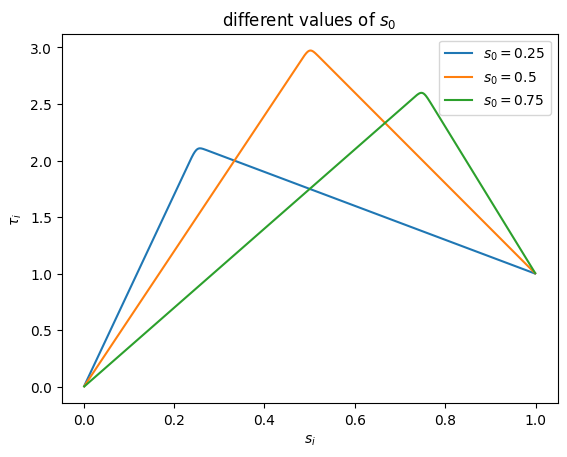

In [21]:
sigma = 0.01 #sigma
h_0=10 #strength

s_0=0.25                #location of the source                                                                                                                
s_list, tau = solution(1000, H, lambda_s)       #getting the numerical solution                                                                                                              
plt.plot(s_list,tau , label = "$s_{0} = 0.25$") #plotting the numerical solution                                                                                                                   

s_0=0.5               #location of the source                                                                                                                 
s_list, tau = solution(1000, H, lambda_s)        #getting the numerical solution                                                                                                             
plt.plot(s_list,tau, label = "$s_{0} = 0.5$")    #plotting the numerical solution                                                                                                                

s_0=0.75            #location of the source                                                                                                                    
s_list, tau = solution(1000, H, lambda_s)         #getting the numerical solution                                                                                                            
plt.plot(s_list,tau, label = "$s_{0} = 0.75$")    #plotting the numerical solution                                                                                                                
plt.title('different values of $s_{0}$') #title
plt.xlabel('$s_i$') #xlabel
plt.ylabel('$\\tau_{i}$') #ylabel
plt.legend()
plt.show()

Here it is interesting to see that just like the graph above, we again see that the maximum temperature is at 0.5 and it is constantly changing with different $s_{0}$ values

#### The Significance of $\sigma$

<font color = blue>
    Finally, create a graph that shows solutions with $h_0 = 10$ and $s_0 = 0.5$, but with
    
$$
\sigma =\in \{0.5, 0.1, 0.05, 0.01, 0.005\}
$$

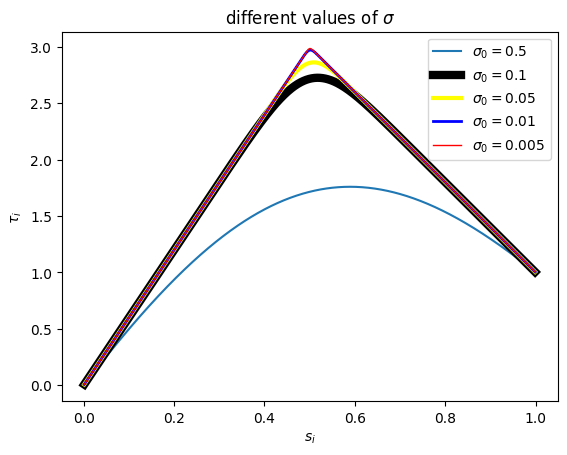

In [22]:
h_0 = 10 #strength
s_0 = 0.5 #location of the source       

sigma = 0.5                                                                            #sigma                                                                                                                       
s_list, tau = solution(1000, H, lambda_s)                                              #getting the numerical solution                                                                                                                                                     
plt.plot(s_list,tau , label = "$\\sigma_{0} = 0.5$")                                   #plotting the numerical solution                                                                                                                                                                  
sigma = 0.1                                                                            #sigma                                                                                                                                                 
s_list, tau = solution(1000, H, lambda_s)                                              #getting the numerical solution                                                                                                                                                      
plt.plot(s_list,tau, label = "$\\sigma_{0} = 0.1$",linewidth = 6,color = "black")      #plotting the numerical solution                                                                                                                                                                                             
sigma = 0.05                                                                           #sigma                                                                                                                                                  
s_list, tau = solution(1000, H, lambda_s)                                              #getting the numerical solution                                                                                                                                                      
plt.plot(s_list,tau, label = "$\\sigma_{0} = 0.05$",linewidth = 3, color = "yellow")   #plotting the numerical solution                                                                                                                                                                                                
sigma = 0.01                                                                           #sigma                                                                                                                                                  
s_list, tau = solution(1000, H, lambda_s)                                              #getting the numerical solution                                                                                                                                                      
plt.plot(s_list,tau, label = "$\\sigma_{0} = 0.01$",linewidth = 2, color = "blue")     #plotting the numerical solution                                                                                                                                                                                              
sigma = 0.005                                                                          #sigma                                                                                                                                                   
s_list, tau = solution(1000, H, lambda_s)                                              #getting the numerical solution                                                                                                                                                      
plt.plot(s_list,tau, label = "$\\sigma_{0} = 0.005$", linewidth = 1, color = "red")    #plotting the numerical solution                                                                                                                                                                                               
plt.title('different values of $\\sigma$')#title
plt.xlabel('$s_i$') #xlabel
plt.ylabel('$\\tau_{i}$') #ylabel
plt.legend()
plt.show()

Again the maximum temperature is at 0.5. The effect of the heat source seem to decrease as the value of $\sigma$ increases just as we would expect

## Final Project Work

<font color = blue>
This week, you should submit your progress on your final project, in a separate Jupyter notebook.  Your notebook should be organized the same way these assignments are (broken into sections, code correctly commented, and short discussions after each section.)  Keep in mind that depending on the topic of your project, I may have very little experience with it, which means your discussions need to be that much better!

At the end, include a brief discussion of what you *intended* to accomplish as compared with what you *did* accomplish, as well as a plan of what you intend to do in the following week.